# 강화학습 구현과 실현

강화학습에는 여러 기법이 있는데 여기에서는 DQN(Deep Q-Network)를 사용하여 강화학습을 진행하였습니다  
DQN은 기존의 Q-Learning에 신경망을 결합한 것입니다  
Q-Learning은 주어진 상태에서 행동을 수행하면서 미래의 효율적인 기댓값을 예측하는 Q 함수를 학습하면서 최적의 정책을 학습히는 기법입니다  

## 설치

In [5]:
!pip install tensorflow
!pip install matplotlib

zsh:1: command not found: pip
zsh:1: command not found: pip


## import

In [1]:
import tensorflow as tf
import numpy as np
import random
import math
import os
tf.compat.v1.disable_eager_execution()

## 파라미터 설정

In [2]:
epsilon = 1  # 랜덤하게 행동할 확률
epsilonMinimumValue = 0.001  # epsilon의 최소값
nbActions = 3  # 행동의 개수 (왼쪽, 대기, 오른쪽)
epoch = 1001  # 게임 반복횟수
hiddenSize = 100  # 히든 레이어 뉴런 개수
maxMemory = 500  # 게임내용을 기억하는 최대 개수
batchSize = 50  # 학습시 데이터 묶음 개수
gridSize = 10  # 격자 크기
nbStates = gridSize * gridSize  # 상태 개수 (픽셀의 개수)
discount = 0.9  # 감소값
learningRate = 0.2  # 학습률

## 딥러닝 모델 설정
입력레이어는 nbStates(100)개 히든레이어는 hiddenSize(100)개 출력레이어는 nbAction(3)개를 가지는 딥러닝 모델을 만들어 준다  

### 입력 레이어
X = tf.compat.v1.placeholder(tf.float32, [None, nbStates]) # 입력값  
placeholder는 변수를 선언할 때 값을 바로 주는 것이 아닌 나중에 값을 던져줄 수 있도록 공간을 미리 만들어 주는 것이다  
따라서 X는 데이터 유형이 float32이고 첫번째 차원의 수는 정해져있지 않고(가변적) 두번째 차원의 수는 nbStates의 값을 가지는 placeholder가 된다  

W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates)))) # 가중치  
입력 레이어의 가중치를 나타내는 W1을 생성해 준다  
변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다
이 정규분포의 표준편차는 $\frac{1}{\sqrt{nbStates}}$가 된다  
이러한 랜덤값들로 nbStates x hiddenSize의 크기를 가지는 행렬을 채워준다  

b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향  
활성화 난이도를 조절해주는 b1을 생성해준다  
학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
hiddenSize개의 랜덤값들을 만들어준다  

input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)  
input layer의 출력값을 만들어준다  
우선 X과 W1의 행렬곱을 한 다음 b1을 더해준다  
그 다음 활성화 함수에 넣어주는데 여기서 활성화 함수는 ReLU 함수가 사용된다  
ReLU 함수: $f(x) = max(0,x)$  

입력값인 X와 가중치인 W1을 행렬곱을 하게 되면 X는 None x nbStates의 크기를 가지는 행렬이고 W1은 nbStates x hiddenSize의 크기를 가지는 행렬이므로 결과는 None x hiddenSize의 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 입력 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b1을 더해준 뒤 활성화 함수에 넣어주면 각각의 입력 레이어 노드의 출력값들을 만들어낼 수 있다

In [3]:
X = tf.compat.v1.placeholder(tf.float32, [None, nbStates]) # 입력값
W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates)))) # 가중치
b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1) # 출력값

### 히든 레이어
W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))  
히든 레이어의 가중치를 나타내는 W2를 생성해준다
입력 레이어와 마찬가지로 변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다  
이 정규분포의 표준편차는 $\frac{1}{\sqrt{hiddenSize}}$가 된다  
이러한 랜덤값들로 hiddenSize x hiddenSize의 크기를 가지는 행렬을 채워준다  

b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향  
활성화 난이도를 조절해주는 b2을 생성해준다  
입력 레이어와 마찬가지로 학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
hiddenSize개의 랜덤값들을 만들어준다  

hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2) # 출력값  
hidden layer의 출력값을 만들어준다  
우선 input_layer(입력 레이어의 출력값)과 W2의 행렬곱을 한 다음 b2을 더해준다  
그 다음 활성화 함수에 넣어주는데 여기서도 활성화 함수는 ReLU 함수가 사용된다  
ReLU 함수: $f(x) = max(0,x)$  

입력 레이어의 출력값인 input_layer와 가중치인 W2을 행렬곱을 하게 되면 input_layer는 None x hiddenSize 크기를 가지는 행렬이고 W2은 hiddenSize x hiddenSize의 크기를 가지는 행렬이므로 결과는 None x hiddenSize의 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 히든 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b2을 더해준 뒤 활성화 함수에 넣어주면 각각의 히든 레이어 노드의 출력값들을 만들어낼 수 있다

In [4]:
W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize)))) # 가중치
b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01)) # 편향
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2) # 출력값

### 출력 레이어  
W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
출력 레이어의 가중치를 나타내는 W3을 생성해준다  
히든 레이어와 마찬가지로 변수의 초기화는 랜덤값으로 주어지는데 이 랜덤값은 양쪽 끝이 잘려있는 정규분포에서 가져오게 된다  
이 정규분포의 표준편차는 $\frac{1}{\sqrt{hiddenSize}}$가 된다  
이러한 랜덤값들로 hiddenSize x hiddenSize의 크기를 가지는 행렬을 채워준다  

b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))  
활성화 난이도를 조절해주는 b3을 생성해준다  
히든 레이어와 마찬가지로 학습데이터가 가중치와 계산되어 나온 값에 더해주어 활성화 난이도를 조절해주는 역할을 해준다  
여기서도 양쪽 끝이 잘려있는 정규분포를 이용하게 되는데 이 정규분포의 표준편차는 0.01이 된다  
bnActions개의 랜덤값들을 만들어준다   

output_layer = tf.matmul(hidden_layer, W3) + b3  
out layer의 출력값을 만들어준다
hidden_layer(히든레이어의 출력값)과 W3의 행렬곱을 한 다음 b3을 더해준다  
회귀 문제이기 때문에 출력 레이어에서는 활성화 함수를 사용하지 않습니다(확인 필요)(항등함수라고 함)

히든 레이어의 출력값인 hidden_layer와 가중치인 W3을 행렬곱을 하게 되면 hidden_layer는 None x hiddenSize 크기를 가지는 행렬이고 W3은 hiddenSize x nbActions 크기를 가지는 행렬이므로 결과는 None x nbActions 크기를 가지는 행렬이 나오게 된다  
이렇게 행렬곱을 하게되면 각각의 출력 레이어 노드에 들어가는 입력값들을 만들어낼 수 있다  
이 값에 편향인 b3을 더해주면 각각의 출력 레이어 노드의 출력값들을 만들어낼 수 있다  

In [5]:
W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

### 목표값 플레이스홀더
목표값 플레이스홀더 Y를 생성한다  
Y는 데이터 유형이 float32이고 첫번째 차원의 수는 정해져있지 않고(가변적) 두번째 차원의 수는 nbActions의 값을 가지는 placeholder가 된다  

In [6]:
Y = tf.compat.v1.placeholder(tf.float32, [None, nbActions])

### 목표값과 출력값의 차이인 코스트
목표값과 출력값의 오차를 구하기 위해 여기서는 평균 제곱 오차를 사용한다  
목표값(Y)에서 출력값(output_layer)을 뺀 다음 제곱을 해준다  
그 다음 나온 값들을 모두 더해준 뒤 2 x batchSize로 나누어준다  
batchSize는 한 번에 모델이 학습하는 데이터 샘플의 개수로 이렇게 2 x batchSize로 나누어주게 되면 코스트를 정규화해주게 된다  
정규화를 통해 학습률과 batchSize에 따른 코스트 크기의 영향을 줄일 수 있다

In [7]:
cost = tf.reduce_sum(tf.square(Y-output_layer)) / (2*batchSize)

### 경사하강법으로 코스트가 최소가 되는 값 찾음
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)  
경사하강법을 이용해 비용이 최소가 되는 값을 찾아준다  
경사하강법을 사용할 때 학습률은 learningRate가 되고 minimize(cost)를 붙여주어 cost를 최소화하도록 설정해준다  

In [8]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)

## 랜덤값 함수
함수 randf는 s이상 e미만의 값을 가지는 랜덤값을 리턴해준다  
(float(random.randrange(0, (e - s) * 9999)) / 10000) + s;
random.randrange는 0부터 (e - s) * 9999 미만의 랜덤값을 만들어준다  
이 값에 float를 붙여 실수로 변환해준 다음 10000으로 나누어주면 0이상 (e - s)미만의 랜덤값이 나오게 된다  
여기에 s를 더해주면 s이상 e미만의 랜덤값이 된다  

In [9]:
def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;

## 환경 클래스
### \_\_init__ 함수
\_\_init__ 함수는 초기화를 시켜준다  

self.gridSize = gridSize  
self.nbStates = self.gridSize * self.gridSize  
self.state = np.empty(3, dtype = np.uint8)  
np.empty는 초기화되지 않은 값으로 배열을 생성해주는 함수로 여기서는 길이가 3인 초기화되지 않은 배열이 생성된다  
배열의 데이터 형식은 uint8(부호 없는 8비트 정수)가 된다  

### observe 함수
observe 함수는 화면정보를 리턴해준다  

canvas = self.drawState()  
drawState함수의 출력값을 canvas에 저장해준다  

canvas = np.reshape(canvas, (-1,self.nbStates))  
np.reshape는 배열을 재구성해주는 함수로 여기서는 canvas 배열을 nbStates개의 열을 가지는 배열로 재구성해준다(행의 개수는 -1로 설정되어 있으므로 자동으로 결정된다)  
그 값을 다시 canvas에 저장해준다    

return canvas  
canvas를 리턴해준다  

### drawState 함수
drawState 함수는 블럭과 바를 표시하여 화면정보를 리턴해준다

canvas = np.zeros((self.gridSize, self.gridSize))  
모든 요소가 0으로 초기화된 self.gridSize x self.gridSize의 크기를 가지는 배열을 생성한다  

canvas[self.state[0]-1, self.state[1]-1] = 1  
self.state는 길이가 3인 배열로 0에는 블럭의 행번호가 1에는 블럭의 열번호를 저장하고 있다  
self.state 값들을 계산할때는 gridSize를 기준으로 계산을 해 1 ~ gridSize이지만 실제로 나타낼 때는 0 ~ gridSize-1이기 때문에 각 값들에 -1을 해준 위치의 배열값을 1로 바꾸어준다   

canvas[self.gridSize-1, self.state[2] -1 - 1] = 1  
canvas[self.gridSize-1, self.state[2] -1] = 1  
canvas[self.gridSize-1, self.state[2] -1 + 1] = 1  
self.State[2]에는 바의 열번호를 저장하고 있다  
따라서 바의 행번호는 gridSize-1(가장 마지막 행)을 해주고 열번호는 self.state[2]-1과 좌우 배열값들을 1로 바꾸어준다    

return canvas  
canvas를 리턴해준다  

### reset 함수
reset함수는 블럭과 바의 위치를 리셋해준다  

initialFruitColumn = random.randrange(1, self.gridSize + 1)  
1이상 gridSize+1 미만의 랜덤값을 initialFruitColumn에 저장해준다  

initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)  
2이상 gridSize미만의 랜덤값을 initialBucketPosition에 저장해준다  
바는 양옆에 픽셀까지 사용하기 때문에 블럭과 다르게 2이상 gridSize미만으로 설정해준다  

self.state = np.array([1, initialFruitColumn, initialBucketPosition])  
블럭의 시작은 항상 맨 위이여야 하기 때문에 state[0]은 1로 설정해주고 state[1]에는 블럭의 열번호인 initialFruitColumn로 설정해주고 state[2]에는 바의 위치인 initialBucketPosition을 설정해준다(바는 항상 행번호가 마지막 행번호로 정해져있기 때문에 열번호만 변경해주면 된다)

return self.getState()
self.getState(현재 상태)를 리턴해준다

### getState 함수  
getState 함수는 현재 상태를 리턴해준다  

stateInfo = self.state  
stateInfo에 현재 state값을 불러온 뒤   

fruit_row = stateInfo[0]  
블럭의 행번호는 fruit_row에 저장  

fruit_col = stateInfo[1]  
블럭의 열번호는 fruit_col에 저장  

basket = stateInfo[2]  
바의 위치는 basket에 저장해준다  

return fruit_row, fruit_col, basket  
각각의 값들을 리턴해준다  

### getReward 함수  
getReward 함수는 보상값을 리턴해준다  

fruitRow, fruitColumn, basket = self.getState()  
우선 getState 함수를 이용해 현재 상태를 가져온다  

if (fruitRow == self.gridSize - 1):   # 만약 블럭의 행번호가 gridSize - 1 과 같다면 (블럭이 가장 마지막 행까지 갔다면)  
&nbsp;&nbsp;&nbsp;&nbsp;if (abs(fruitColumn - basket) <= 1):  # 블럭의 열번호 - 바의 위치에 절대값이 <= 1이라면 (0이라면 == 위치가 같다면)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;return 1   # 1을 리턴해준다  
&nbsp;&nbsp;&nbsp;&nbsp;else:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;return -1   # 위치가 같지 않다면 -1을 리턴해준다  
else:   # 블럭의 행번호가 gridSize - 1 과 같지 않다면 (블럭이 아직 가장 마지막 행까지 가지 않았다면)  
&nbsp;&nbsp;&nbsp;&nbsp;return 0   # 0을 리턴해준다  

### isGameOver 함수
isGameOver 함수는 게임이 끝났는지의 여부를 리턴해준다   

if (self.state[0] == self.gridSize - 1):  # 만약 블럭의 행번호가 girdSize-1과 같다면 (블럭이 가장 마지막 행까지 갔다면)  
&nbsp;&nbsp;&nbsp;&nbsp;return True # True를 리턴해준다  
else: # 블럭이 가장 마지막 행까지 가지 않았다면  
&nbsp;&nbsp;&nbsp;&nbsp;return False  # False를 리턴해준다  
    
### updateState 함수
updateState 함수는 action에 따라 바의 위치를 업데이트해주고 블럭의 위치를 업데이트해준다

if (action == 1): # action이 1이면 왼쪽으로 이동시켜준다  
&nbsp;&nbsp;&nbsp;&nbsp;action = -1    
elif (action == 2): # action이 2이면 그대로 있는다  
&nbsp;&nbsp;&nbsp;&nbsp;action = 0   
else:  # action이 0이면 오른쪽으로 이동시켜준다  
&nbsp;&nbsp;&nbsp;&nbsp;action = 1  

fruitRow, fruitColumn, basket = self.getState()  
getState함수를 이용해 현재상태를 가져온다  

newBasket = min(max(2, basket + action), self.gridSize - 1)  # 바 위치 변경  
새로운 바의 위치는 우선 2와 bascket + action 중 큰 것을 고른 다음 gridSize - 1과 비교하여 더 작은 값으로 설정해준다 (2이상 gridSize-1이하의 값으로 설정된다 바는 양옆의 픽셀까지 사용하기 때문에 2와 gridSize - 1로 설정해준다)  

fruitRow = fruitRow + 1  # 블럭을 아래로 이동  
블럭의 행번호도 하나 추가해준다  

self.state = np.array([fruitRow, fruitColumn, newBasket])  
state값을 새로운 값들로 업데이트 해준다  

### act 함수
act 함수는 행동을 수행한다  

self.updateState(action)  
updateState 함수를 사용해 바의 위치와 블럭의 위치를 업데이트 시켜준다  

reward = self.getReward()  
getReward 함수를 사용해 보상값을 가져오고  

gameOver = self.isGameOver()  
isGameOver 함수를 사용해 게임이 끝났는지 확인한다  

return self.observe(), reward, gameOver, self.getState()  
앞에서 가져온 값들을 리턴해준다  

In [10]:
class CatchEnvironment():
    # 초기화
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8) 
        
    # 화면정보 리턴
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas
    
    # 블럭과 바를 표시하여 화면정보 리턴
    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
    
        # 블럭 표시
        canvas[self.state[0]-1, self.state[1]-1] = 1

        # 바 표시
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1    
        return canvas 

    # 블럭과 바 위치 초기화
    def reset(self): 
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition]) 
        return self.getState()

    # 상태 리턴
    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

    # 보상값 리턴
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
            return 0

    # 게임오버 검사
    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1): 
            return True 
        else: 
            return False 

    # 상태 업데이트
    def updateState(self, action):
        if (action == 1):
            action = -1  # 왼쪽 이동
        elif (action == 2):
            action = 0  # 대기
        else:
            action = 1  # 오른쪽 이동
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1)  # 바 위치 변경
        fruitRow = fruitRow + 1  # 블럭을 아래로 이동
        self.state = np.array([fruitRow, fruitColumn, newBasket])

    # 행동 수행 (1->왼쪽, 2->대기, 3->오른쪽)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState() 

## 메모리 클래스 (게임내용을 저장하고 나중에 배치로 묶어 학습에 사용)

In [11]:
class ReplayMemory:

    # 초기화
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool_)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8) 
        self.count = 0
        self.current = 0

    # 게임내용 추가
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    # 게임내용을 배치로 묶어서 리턴
    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)
        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        for i in range(chosenBatchSize):
            # 메모리에서 랜덤하게 선택
            randomIndex = random.randrange(0, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))
            target = sess.run(model, feed_dict={X: current_inputState})

            current_nextState = np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})      

            # 다음 상태의 최대 Q값
            nextStateMaxQ = np.amax(current_outputs)


            if (self.gameOver[randomIndex] == True):
                # 게임오버일때 Q값은 보상값으로 설정
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # Q값을 계산
                # reward + discount(gamma) * max_a' Q(s',a')
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] +self.discount * nextStateMaxQ
                inputs[i] = current_inputState
                targets[i] = target
        return inputs, targets

##  메인함수

In [12]:
def main(_):
    print("Training new model")

    # 환경 정의
    env = CatchEnvironment(gridSize)

    # 메모리 정의
    memory = ReplayMemory(gridSize, maxMemory, discount)

    # 세이버 설정
    saver = tf.compat.v1.train.Saver()
    
    winCount = 0
    with tf.compat.v1.Session() as sess:   
        tf.compat.v1.initialize_all_variables().run() 

        for i in range(epoch):
            err = 0
            env.reset()
      
            isGameOver = False

            currentState = env.observe()
            
            while (isGameOver != True):
                action = -9999 

                # 랜덤으로 행동을 할지 Q값에 따라 행동할지 결정
                global epsilon
                if (randf(0, 1) <= epsilon):
                    action = random.randrange(1, nbActions+1)
                else:          
                    q = sess.run(output_layer, feed_dict={X: currentState})          
                    index = q.argmax()
                    action = index + 1     

 

                # 랜덤으로 행동할 확률 감소
                if (epsilon > epsilonMinimumValue):
                  epsilon = epsilon * 0.999
                
                # 행동 수행
                nextState, reward, gameOver, stateInfo = env.act(action)

                # 승리 횟수 설정
                if (reward == 1):
                    winCount = winCount + 1

                # 메모리에 저장
                memory.remember(currentState, action, reward, nextState, gameOver)

                # 다음 상태 설정
                currentState = nextState
                isGameOver = gameOver
                
                # 입력과 출력 데이터 배치를 구함
                inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)
        
                # 학습 수행
                _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})  
                err = err + loss

            print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)*100))

        # 모델 세션 저장
        #save_path = saver.save(sess, os.getcwd()+"/model.ckpt")
        save_path = saver.save(sess,'test')

        #print("Model saved in file: %s" % save_path)
        print("Finish")

## 메인 함수 실행

In [13]:
if __name__ == '__main__':
    tf.compat.v1.app.run()

Training new model
Instructions for updating:
Use `tf.global_variables_initializer` instead.


W1108 20:35:07.650410 25552 deprecation.py:50] From C:\Users\Ryu\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\tf_should_use.py:288: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch 0: err = 0.0047328555901913205: Win count = 0 Win ratio = 0.0
Epoch 1: err = 0.0077804672182537615: Win count = 0 Win ratio = 0.0
Epoch 2: err = 0.008060148975346237: Win count = 0 Win ratio = 0.0
Epoch 3: err = 0.006940631661564112: Win count = 1 Win ratio = 25.0
Epoch 4: err = 0.00773087766719982: Win count = 1 Win ratio = 20.0
Epoch 5: err = 0.009311863803304732: Win count = 1 Win ratio = 16.666666666666664
Epoch 6: err = 0.010141215578187257: Win count = 1 Win ratio = 14.285714285714285
Epoch 7: err = 0.008453260525129735: Win count = 1 Win ratio = 12.5
Epoch 8: err = 0.008302775851916522: Win count = 1 Win ratio = 11.11111111111111
Epoch 9: err = 0.009998365887440741: Win count = 1 Win ratio = 10.0
Epoch 10: err = 0.008982798841316253: Win count = 1 Win ratio = 9.090909090909092
Epoch 11: err = 0.008265542157460004: Win count = 2 Win ratio = 16.666666666666664
Epoch 12: err = 0.007598576426971704: Win count = 2 Win ratio = 15.384615384615385
Epoch 13: err = 0.007452719670254

KeyboardInterrupt: 

# 플레이 & 시각화

## import

In [15]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab as pl
import time
import tensorflow as tf
import math
import os

In [ ]:
gridSize = 10 # The size of the grid that the agent is going to play the game on.
maxGames = 100
env = CatchEnvironment(gridSize)
winCount = 0
loseCount = 0
numberOfGames = 0

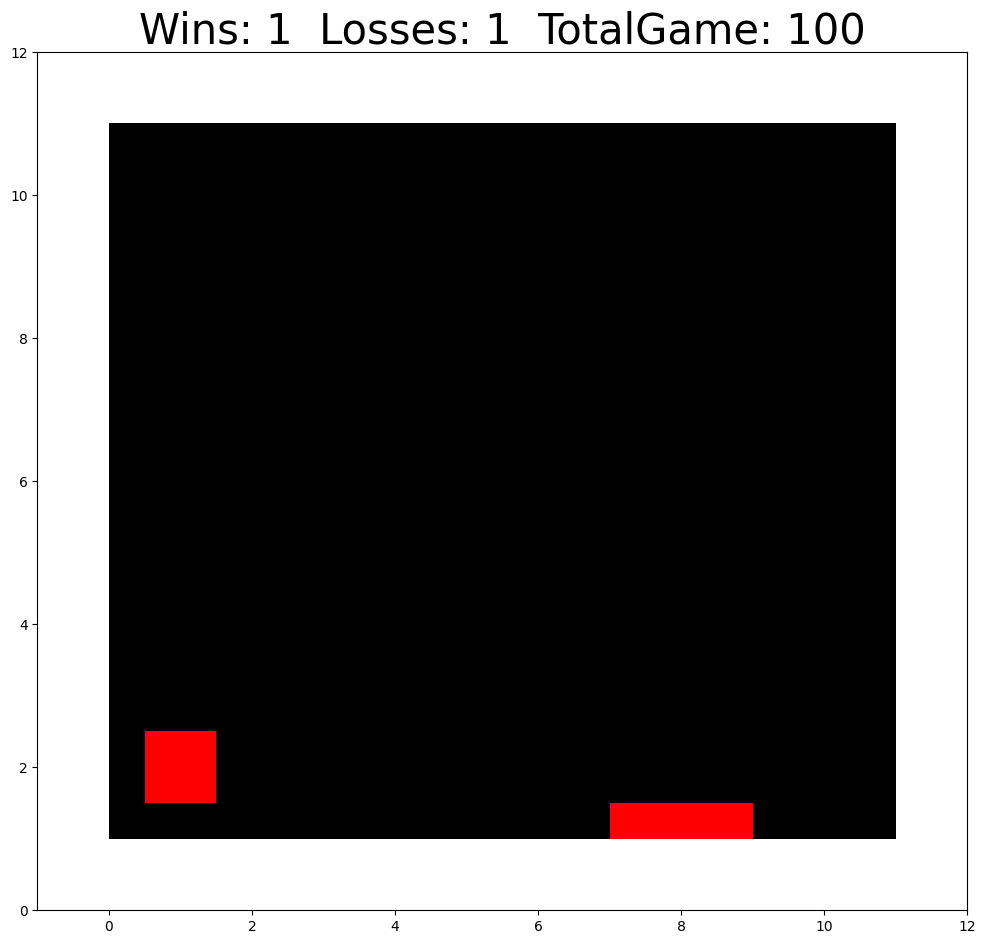

In [24]:
ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

saver = tf.compat.v1.train.Saver()

def drawState(fruitRow, fruitColumn, basket):
    global gridSize
      # column is the x axis
    fruitX = fruitColumn 
      # Invert matrix style points to coordinates
    fruitY = (gridSize - fruitRow + 1)
    statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
    axis.set_title(statusTitle, fontsize=30)
    for p in [
        patches.Rectangle(
            ((ground - 1), (ground)), 11, 10, facecolor="#000000"      # Black
        ),
        patches.Rectangle(
            (basket - 1, ground), 2, 0.5, facecolor="#FF0000"     # No background
        ),
        patches.Rectangle(
            (fruitX - 0.5, fruitY - 0.5), 1, 1, facecolor="#FF0000"       # red 
        ),   
        ]:
        axis.add_patch(p)
    display.clear_output(wait=True)
    display.display(pl.gcf())

with tf.compat.v1.Session() as sess:    
    # Restore variables from disk.
    saver.restore(sess, 'test')
    print('saved model is loaded!')

    while (numberOfGames < maxGames):
        numberOfGames = numberOfGames + 1
     
    # The initial state of the environment.
    isGameOver = False
    fruitRow, fruitColumn, basket = env.reset()
    currentState = env.observe()
    drawState(fruitRow, fruitColumn, basket)

    while (isGameOver != True):
        # Forward the current state through the network.
        q = sess.run(output_layer, feed_dict={X: currentState})
        # Find the max index (the chosen action).
        index = q.argmax()
        action = index + 1
        nextState, reward, gameOver, stateInfo = env.act(action)    
        fruitRow = stateInfo[0]
        fruitColumn = stateInfo[1]
        basket = stateInfo[2]
     
        # Count game results
        if (reward == 1):
            winCount = winCount + 1
        elif (reward == -1):
            loseCount = loseCount + 1

        currentState = nextState
        isGameOver = gameOver
        drawState(fruitRow, fruitColumn, basket)
        time.sleep(0.4)

display.clear_output(wait=True)